Total amount of images: 354


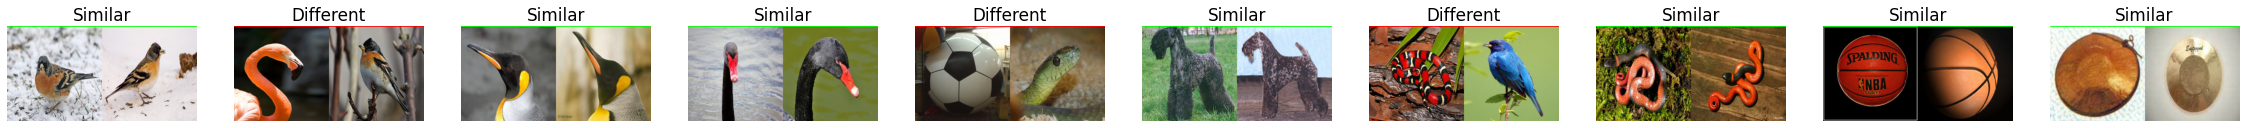

In [1]:
import util

folders = util.load_images('data/dataset_pairs')
data, labels = util.create_pairs(folders)
data, labels = util.shuffle_data(data, labels)
data_split, labels_split = util.split_data(data, labels)
data_train, data_val, data_test = data_split
labels_train, labels_val, labels_test = labels_split

util.visualize(data_train, labels_train)

In [2]:
# Import libraries and modules
import numpy as np
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Lambda
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Resizing
from keras.layers import BatchNormalization
from keras.metrics import CosineSimilarity
from keras.metrics import BinaryAccuracy
from sklearn.metrics.pairwise import euclidean_distances
from tensorflow.keras import layers
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Feature Extractor M1

In [3]:
# input_shape = (224, 224, 3)

# # embedding extractor
# embedding_extractor = Sequential(name='embedding_extractor')
# base_model = MobileNetV2(input_shape=(input_shape), include_top = False, weights='imagenet')
# base_model.trainable = False
# embedding_extractor.add(base_model)

# embedding_extractor.add(GlobalAveragePooling2D())
# embedding_extractor.add(Dense(256, activation='relu'))
# embedding_extractor.add(Dropout(0.5))
# embedding_extractor.add(Dense(128, activation='relu'))
# embedding_extractor.add(Dropout(0.5))
# embedding_extractor.add(Dense(64, activation='relu'))

# embedding_extractor.summary()

# # Input pair
# input_image_1 = Input(input_shape)
# input_image_2 = Input(input_shape)

# # Output pair
# encoded_image_1 = embedding_extractor(input_image_1)
# encoded_image_2 = embedding_extractor(input_image_2)

# # Model
# feature_extraction_model = Model(inputs=[input_image_1, input_image_2], outputs=[encoded_image_1, encoded_image_2], name='feature_extractor')
# feature_extraction_model.summary()

In [4]:
# # Normalize results

# features = feature_extraction_model.predict([data_test[:, 0], data_test[:, 1]])

# similarities = []

# for i in range(len(features[0])):
#     similarities.append(util.cosine_similarity(features[0][i], features[1][i]))

# max_similarity = 0
# min_similarity = 1
# mean_distance = np.mean(similarities)
# variance_distance = np.var(similarities)
# standart_deviation = np.sqrt(variance_distance)

# top_margin = mean_distance + 2 * standart_deviation
# bottom_margin = mean_distance - 2 * standart_deviation

# for i in similarities:
#     # Same image

#      # Calculate the min and max similarity
     
#     if i > max_similarity:
#         max_similarity = i
#     if i < min_similarity:
#         min_similarity = i

#     # if i > outlier_margin or i < 1 - outlier_margin:
    
# print("Max similarity: {:.3f}".format(max_similarity))
# print("Min similarity: {:.3f}".format(min_similarity))
# print("Mean similarity: {:.3f}".format(mean_distance))
# print("Variance similarity: {:.3f}".format(variance_distance))
# print("Standart deviation: {:.3f}".format(standart_deviation))
# print("Top margin: {:.3f}".format(top_margin))
# print("Bottom margin: {:.3f}".format(bottom_margin))

## M3

In [5]:
distance_input = Input(1280)
# distance_input = Input(62720)

distance_output = Dense(256, activation='relu')(distance_input)
distance_output = Dropout(0.2)(distance_output)
distance_output = Dense(128, activation='relu')(distance_input)
distance_output = Dropout(0.3)(distance_output)
distance_output = Dense(64, activation='relu')(distance_output)
distance_output = Dropout(0.4)(distance_output)
distance_output = Dense(1, activation='sigmoid')(distance_output)

classification_model = Model(inputs=distance_input, outputs=distance_output, name='classification_model')

In [6]:

BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.0005
DECAY_RATE = 1e-5

# Inputs
# inputs = [Input(input_shape), Input(input_shape)]

# Feature Extraction Model
# feature_extractor_layer = feature_extraction_model(inputs)

# # Distance layer LAMBDA
# # distance_layer = Lambda(util.pairwise_euclidean_distance)(feature_extractor_layer) 

# merge_layer = Lambda(util.pairwise_euclidean_distance)(feature_extractor_layer)
# normal_layer = BatchNormalization()(merge_layer)
# output_layer = Dense(1, activation='sigmoid', dtype='float32')(normal_layer)

input_shape = (224, 224, 3)

# Source <https://keras.io/examples/vision/siamese_contrastive/>

embedding_extractor = Sequential(name='embedding_extractor')
base_model = MobileNetV2(input_shape=(input_shape), include_top = False, weights='imagenet')
base_model.trainable = False
embedding_extractor.add(base_model)
embedding_extractor.add(Dense(128, activation='relu'))
embedding_extractor.add(Dropout(0.5))
embedding_extractor.add(Dense(64, activation='relu'))
embedding_extractor.add(GlobalAveragePooling2D())

# Input pair
input_image_1 = Input(input_shape)
input_image_2 = Input(input_shape)

# Output pair
encoded_image_1 = embedding_extractor(input_image_1)
encoded_image_2 = embedding_extractor(input_image_2)

merge_layer = Lambda(util.pairwise_euclidean_distance)([encoded_image_1, encoded_image_2])
normal_layer = BatchNormalization()(merge_layer)
output_layer = Dense(1, activation='sigmoid', dtype='float32')(normal_layer)

# Full Model
siamese = Model(inputs=[input_image_1, input_image_2], outputs=output_layer, name='model')

siamese.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[BinaryAccuracy()])

siamese.summary()

history = siamese.fit(
    [data_train[:, 0], data_train[:, 1]], 
    labels_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, 
    validation_data=([data_val[:, 0], data_val[:, 1]], labels_val))

# evaluate
score = siamese.evaluate(
    [data_test[:, 0], data_test[:, 1]], 
    labels_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding_extractor (Sequentia  (None, 64)          2430208     ['input_3[0][0]',                
 l)                                                               'input_4[0][0]']            

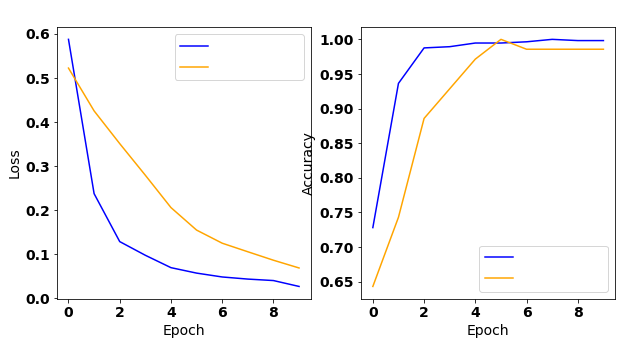

In [7]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	fig, ax = plt.subplots(1, 2, figsize=(10, 5))
	ax[0].set_title('Cross Entropy Loss')
	ax[0].set_xlabel('Epoch')
	ax[0].set_ylabel('Loss')
	ax[0].plot(history.history['loss'], color='blue', label='train')
	ax[0].plot(history.history['val_loss'], color='orange', label='validation')
	ax[0].legend()

	# plot accuracy
	ax[1].set_title('Classification Accuracy')
	ax[1].set_xlabel('Epoch')
	ax[1].set_ylabel('Accuracy')
	ax[1].plot(history.history['binary_accuracy'], color='blue', label='train')
	ax[1].plot(history.history['val_binary_accuracy'], color='orange', label='validation')
	ax[1].legend()
	
	plt.show()

summarize_diagnostics(history)

Best accuracy: 0.9444444444444444
Test
- Amount of TP: 34
- Amount of TN: 34
- Amount of FP: 2
- Amount of FN: 2
- AUC score: 0.9544753086419753
- Accuracy: 0.9444444444444444
- Recall: 0.9444444444444444
- Precision: 0.9444444444444444
- F1: 0.9444444444444444
- Kappa: 0.8888888888888888


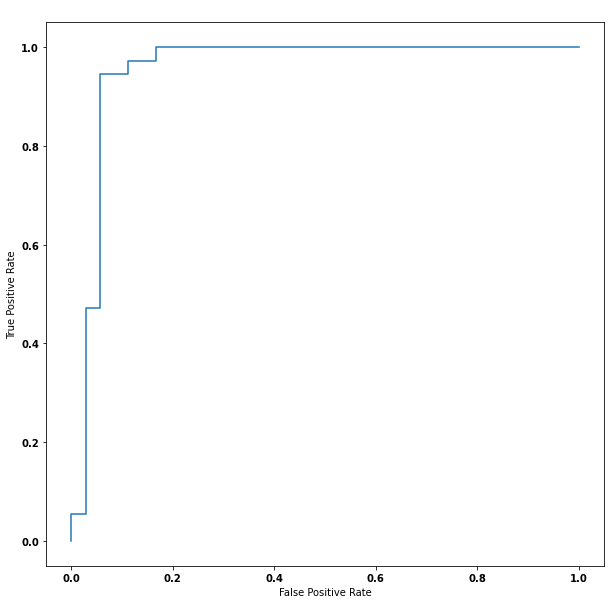

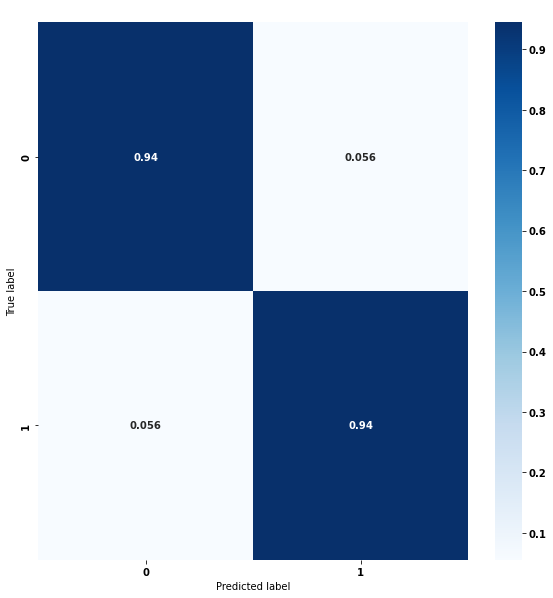

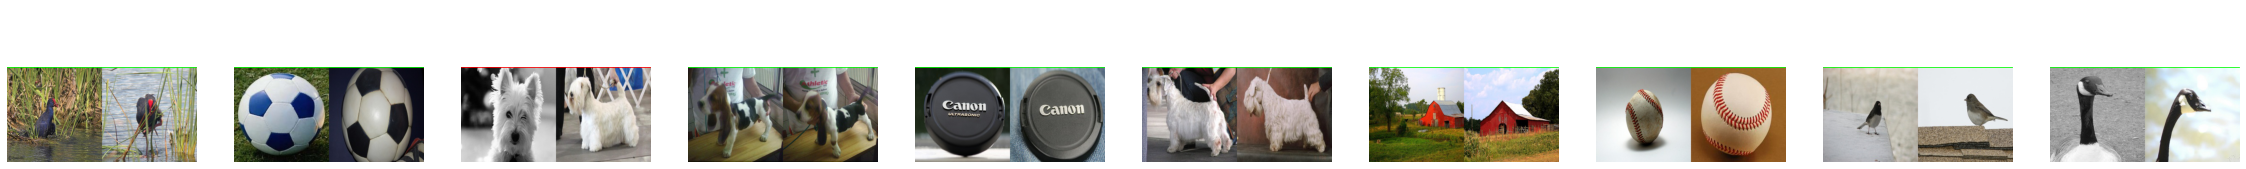

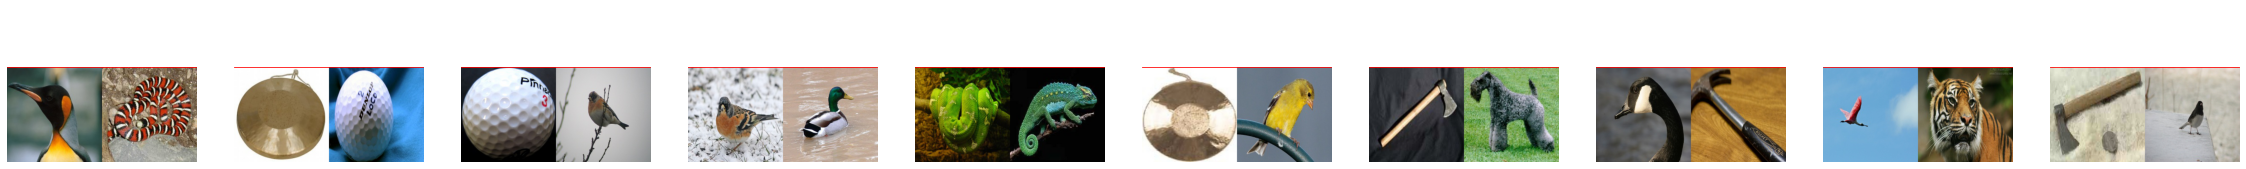

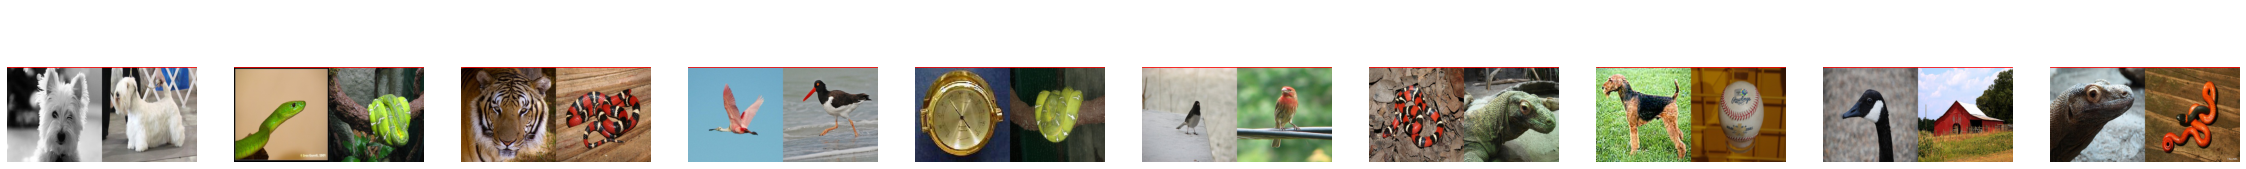

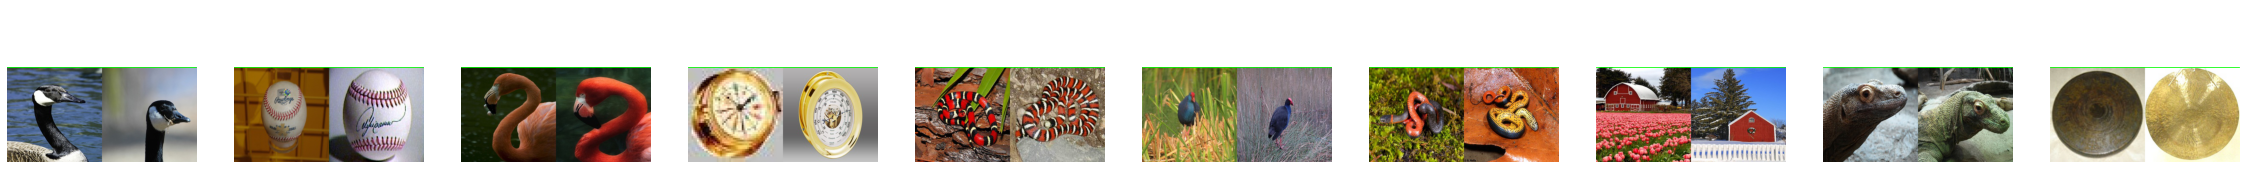

Threshold:  0.42500000000000027


In [12]:
import util
util.evaluate(data=data_test, labels=labels_test, similarity=siamese.predict([data_test[:,0],data_test[:,1]]), name="Test")

In [9]:
# embedding_extractor.save('models/embeddings/binary_cross_entropy_loss_embedding_extractor.h5')

In [10]:
# !tensorflowjs_converter --input_format keras --weight_shard_size_bytes 1073741824 models/embeddings/binary_cross_entropy_loss_embedding_extractor.h5 models/embeddings/binary_cross_entropy_loss_embedding_extractor.tfjs